<a href="https://colab.research.google.com/github/kenpurin/Retrosynthesis_Pytorch/blob/main/Transformer_Retrosynthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LANGUAGE TRANSLATION WITH TRANSFORMER

In [3]:
!nvidia-smi

Thu Jun 10 07:58:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#load data and insatall

In [3]:
!git clone https://github.com/kenpurin/Retrosynthesis_TF.git

Cloning into 'Retrosynthesis_TF'...
remote: Enumerating objects: 181, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 181 (delta 94), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (181/181), 3.99 MiB | 940.00 KiB/s, done.
Resolving deltas: 100% (94/94), done.


In [4]:
!pip3 install rich
!pip3 show torch

     |████████████████████████████████| 204kB 14.8MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
Name: torch
Version: 1.8.1+cu101
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.7/dist-packages
Requires: typing-extensions, numpy
Required-by: torchvision, torchtext, fastai


# Data Processing

In [5]:
import math
import torchtext
import torch
import torch.nn as nn
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
from torchtext.utils import download_from_url, extract_archive
from torch import Tensor
import io
import time
from rich import print
import matplotlib.pyplot as plt


In [6]:
torch.manual_seed(42)
torch.use_deterministic_algorithms(True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.__version__)
print(torch.cuda.is_available())

if device.type == 'cuda':
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
!nvcc --version

1.8.1+cu101

True

Tesla V100-SXM2-16GB

Memory Usage:

Allocated: 0.0 GB

Cached:    0.0 GB

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [7]:
#load data USPTO-50K
train_src_filepaths='Retrosynthesis_TF/USPTO-50K/src/src-train.txt'
train_tgt_filepaths='Retrosynthesis_TF/USPTO-50K/tgt/tgt-train.txt'
val_src_filepaths='Retrosynthesis_TF/USPTO-50K/src/src-val.txt'
val_tgt_filepaths='Retrosynthesis_TF/USPTO-50K/tgt/tgt-val.txt'
test_src_filepaths='Retrosynthesis_TF/USPTO-50K/src/src-test.txt'
test_tgt_filepaths='Retrosynthesis_TF/USPTO-50K/tgt/tgt-test.txt'

In [8]:
#build_vocab
src_filepath='Retrosynthesis_TF/USPTO-50K/src/src.txt'
tgt_filepath='Retrosynthesis_TF/USPTO-50K/tgt/tgt.txt'

In [9]:
#https://pytorch.org/text/stable/data_utils.html use toktok or spacy
tokenizer = get_tokenizer('toktok')

In [10]:
def build_vocab(filepath, tokenizer):
  counter = Counter()
  with io.open(filepath, encoding="utf8") as f:
    for string_ in f:
      counter.update(tokenizer(string_))
  return Vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])
src_vocab = build_vocab(src_filepath,tokenizer)
tgt_vocab = build_vocab(tgt_filepath,tokenizer)

In [11]:
def data_process(filepaths1,filepaths2):
  raw_src_iter = iter(io.open(filepaths1, encoding="utf8"))
  raw_tgt_iter = iter(io.open(filepaths2, encoding="utf8"))
  data = []
  for (raw_src, raw_tgt) in zip(raw_src_iter, raw_tgt_iter):
    src_tensor_ = torch.tensor([src_vocab[token] for token in tokenizer(raw_src.rstrip("\n"))],
                            dtype=torch.long)
    tgt_tensor_ = torch.tensor([tgt_vocab[token] for token in tokenizer(raw_tgt.rstrip("\n"))],
                            dtype=torch.long)
    data.append((src_tensor_, tgt_tensor_))
  return data

In [12]:
train_data = data_process(train_src_filepaths,train_tgt_filepaths)
val_data = data_process(val_src_filepaths,val_tgt_filepaths)
test_data = data_process(test_src_filepaths,test_tgt_filepaths)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#default BATCH_SIZE =128
BATCH_SIZE = 32
PAD_IDX = src_vocab['<pad>']
BOS_IDX = src_vocab['<bos>']
EOS_IDX = src_vocab['<eos>']

# DataLoader

In [14]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def generate_batch(data_batch):
  src_batch, tgt_batch = [], []
  for (src_item, tgt_item) in data_batch:
    src_batch.append(torch.cat([torch.tensor([BOS_IDX]), src_item, torch.tensor([EOS_IDX])], dim=0))
    tgt_batch.append(torch.cat([torch.tensor([BOS_IDX]), tgt_item, torch.tensor([EOS_IDX])], dim=0))
  src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
  tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
  return src_batch, tgt_batch

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE,
                       shuffle=True, collate_fn=generate_batch)

#Transformer

In [15]:
#https://pytorch.org/docs/master/nn.html?highlight=multiheadattention#torch.nn.MultiheadAttention
from torch.nn import (TransformerEncoder, TransformerDecoder,
                      TransformerEncoderLayer, TransformerDecoderLayer)


class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers: int, num_decoder_layers: int,
                 emb_size: int, src_vocab_size: int, tgt_vocab_size: int,
                 dim_feedforward:int = 512, dropout:float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        #TransformerEncoderLayer is made up of self-attn and feedforward network.
        encoder_layer = TransformerEncoderLayer(d_model=emb_size, nhead=NHEAD,
                                                dim_feedforward=dim_feedforward)
        #TransformerEncoder is a stack of N encoder layers
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        #	TransformerDecoderLayer is made up of self-attn, multi-head-attn and feedforward network.
        decoder_layer = TransformerDecoderLayer(d_model=emb_size, nhead=NHEAD,
                                                dim_feedforward=dim_feedforward)
        #TransformerDecoder is a stack of N decoder layers
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self, src: Tensor, trg: Tensor, src_mask: Tensor,
                tgt_mask: Tensor, src_padding_mask: Tensor,
                tgt_padding_mask: Tensor, memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        memory = self.transformer_encoder(src_emb, src_mask, src_padding_mask)
        outs = self.transformer_decoder(tgt_emb, memory, tgt_mask, None,
                                        tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer_encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer_decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [16]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding +
                            self.pos_embedding[:token_embedding.size(0),:])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [17]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
  src_seq_len = src.shape[0]
  tgt_seq_len = tgt.shape[0]

  tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
  src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

  src_padding_mask = (src == PAD_IDX).transpose(0, 1)
  tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
  return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [22]:
# Training hyperparameters
#default BATCH_SIZE = 128 NUM_ENCODER_LAYERS = 3 NUM_DECODER_LAYERS = 3

SRC_VOCAB_SIZE = len(src_vocab)
TGT_VOCAB_SIZE = len(tgt_vocab)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 5
NUM_DECODER_LAYERS = 5
NUM_EPOCHS = 500

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS,
                                 EMB_SIZE, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE,
                                 FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
#model 
transformer = transformer.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
#default optimizer  lr=0.0001 ,betas=(0.9, 0.98) ,eps=1e-9
optimizer = torch.optim.Adam(
    transformer.parameters(), lr=0.0001, betas=(0.9, 0.998), eps=1e-9
)

In [23]:
#show model
print(transformer)

Seq2SeqTransformer(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (2): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (3): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (4): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (transformer_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0): TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplac

#Save checkpoint

In [24]:
load_model = True
save_model = True

In [25]:
def save_checkpoint(state, filename):
    #filename="my_checkpoint_"+str(epoch)+".pth"
    print("=> Saving checkpoint")
    torch.save(state, filename)

#Load checkpoint

In [48]:
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [49]:
if load_model:
    load_checkpoint(torch.load("/content/gdrive/MyDrive/code retrosynthesis/checkpoint/test1/my_checkpoint_500_test1.pth"), transformer, optimizer)



=> Loading checkpoint

# Train and Evaluate function

In [26]:
def train_epoch(model, train_iter, optimizer):
  model.train()
  losses = 0
  for idx, (src, tgt) in enumerate(train_iter):
      src = src.to(device)
      tgt = tgt.to(device)

      tgt_input = tgt[:-1, :]

      src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

      logits = model(src, tgt_input, src_mask, tgt_mask,
                                src_padding_mask, tgt_padding_mask, src_padding_mask)

      optimizer.zero_grad()

      tgt_out = tgt[1:,:]
      loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
      loss.backward()

      optimizer.step()
      losses += loss.item()
  return losses / len(train_iter)


def evaluate(model, val_iter):
  model.eval()
  losses = 0
  for idx, (src, tgt) in (enumerate(valid_iter)):
    src = src.to(device)
    tgt = tgt.to(device)

    tgt_input = tgt[:-1, :]

    src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

    logits = model(src, tgt_input, src_mask, tgt_mask,
                              src_padding_mask, tgt_padding_mask, src_padding_mask)
    tgt_out = tgt[1:,:]
    loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
    losses += loss.item()
  return losses / len(val_iter)

#Train model

In [27]:
!nvidia-smi

Wed Jun  9 12:49:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    39W / 300W |   1517MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [28]:
train_loss_ex = []
val_loss_ex = []
epoch_ex=[]
for epoch in range(1, NUM_EPOCHS+1):
  start_time = time.time()
  train_loss = train_epoch(transformer, train_iter, optimizer)
  end_time = time.time()
  val_loss = evaluate(transformer, valid_iter)
  #Save the general checkpoint
  if epoch%100==0:
    filename="my_checkpoint_"+str(epoch)+".pth"
    print("true")
    checkpoint = {"state_dict": transformer.state_dict(),"optimizer": optimizer.state_dict(),}
    save_checkpoint(checkpoint,filename)

  print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "
          f"Epoch time = {(end_time - start_time):.3f}s"))
  #plot
  train_loss_ex.append(train_loss)
  epoch_ex.append(epoch)
  val_loss_ex.append(val_loss)
  
print("Done!")

Epoch: 1, Train loss: 1.208, Val loss: 0.801, Epoch time = 87.676s

Epoch: 2, Train loss: 0.789, Val loss: 0.636, Epoch time = 87.651s

Epoch: 3, Train loss: 0.658, Val loss: 0.534, Epoch time = 88.223s

Epoch: 4, Train loss: 0.578, Val loss: 0.472, Epoch time = 87.843s

Epoch: 5, Train loss: 0.516, Val loss: 0.416, Epoch time = 88.009s

Epoch: 6, Train loss: 0.462, Val loss: 0.372, Epoch time = 88.112s

Epoch: 7, Train loss: 0.413, Val loss: 0.331, Epoch time = 88.154s

Epoch: 8, Train loss: 0.370, Val loss: 0.280, Epoch time = 87.747s

Epoch: 9, Train loss: 0.330, Val loss: 0.253, Epoch time = 87.673s

Epoch: 10, Train loss: 0.297, Val loss: 0.224, Epoch time = 87.847s

Epoch: 11, Train loss: 0.269, Val loss: 0.199, Epoch time = 87.775s

Epoch: 12, Train loss: 0.245, Val loss: 0.183, Epoch time = 87.710s

Epoch: 13, Train loss: 0.223, Val loss: 0.165, Epoch time = 87.521s

Epoch: 14, Train loss: 0.204, Val loss: 0.154, Epoch time = 87.208s

Epoch: 15, Train loss: 0.188, Val loss: 0.142, Epoch time = 87.498s

Epoch: 16, Train loss: 0.173, Val loss: 0.135, Epoch time = 87.753s

Epoch: 17, Train loss: 0.161, Val loss: 0.127, Epoch time = 87.739s

Epoch: 18, Train loss: 0.151, Val loss: 0.122, Epoch time = 88.015s

Epoch: 19, Train loss: 0.142, Val loss: 0.116, Epoch time = 88.502s

Epoch: 20, Train loss: 0.134, Val loss: 0.113, Epoch time = 88.131s

Epoch: 21, Train loss: 0.127, Val loss: 0.107, Epoch time = 88.035s

Epoch: 22, Train loss: 0.120, Val loss: 0.108, Epoch time = 88.099s

Epoch: 23, Train loss: 0.115, Val loss: 0.104, Epoch time = 87.968s

Epoch: 24, Train loss: 0.109, Val loss: 0.099, Epoch time = 88.082s

Epoch: 25, Train loss: 0.105, Val loss: 0.096, Epoch time = 87.765s

Epoch: 26, Train loss: 0.101, Val loss: 0.097, Epoch time = 87.780s

Epoch: 27, Train loss: 0.096, Val loss: 0.094, Epoch time = 87.957s

Epoch: 28, Train loss: 0.093, Val loss: 0.092, Epoch time = 87.995s

Epoch: 29, Train loss: 0.089, Val loss: 0.092, Epoch time = 87.773s

Epoch: 30, Train loss: 0.087, Val loss: 0.088, Epoch time = 88.246s

Epoch: 31, Train loss: 0.083, Val loss: 0.090, Epoch time = 88.381s

Epoch: 32, Train loss: 0.081, Val loss: 0.088, Epoch time = 88.571s

Epoch: 33, Train loss: 0.078, Val loss: 0.088, Epoch time = 87.658s

Epoch: 34, Train loss: 0.076, Val loss: 0.089, Epoch time = 88.356s

Epoch: 35, Train loss: 0.074, Val loss: 0.087, Epoch time = 88.120s

Epoch: 36, Train loss: 0.072, Val loss: 0.085, Epoch time = 88.434s

Epoch: 37, Train loss: 0.069, Val loss: 0.087, Epoch time = 88.298s

Epoch: 38, Train loss: 0.067, Val loss: 0.085, Epoch time = 88.553s

Epoch: 39, Train loss: 0.066, Val loss: 0.087, Epoch time = 88.838s

Epoch: 40, Train loss: 0.064, Val loss: 0.085, Epoch time = 88.707s

Epoch: 41, Train loss: 0.062, Val loss: 0.084, Epoch time = 88.277s

Epoch: 42, Train loss: 0.061, Val loss: 0.083, Epoch time = 88.629s

Epoch: 43, Train loss: 0.059, Val loss: 0.085, Epoch time = 88.162s

Epoch: 44, Train loss: 0.058, Val loss: 0.085, Epoch time = 88.434s

Epoch: 45, Train loss: 0.057, Val loss: 0.084, Epoch time = 88.313s

Epoch: 46, Train loss: 0.055, Val loss: 0.083, Epoch time = 88.482s

Epoch: 47, Train loss: 0.054, Val loss: 0.084, Epoch time = 88.575s

Epoch: 48, Train loss: 0.053, Val loss: 0.085, Epoch time = 89.000s

Epoch: 49, Train loss: 0.052, Val loss: 0.084, Epoch time = 88.916s

Epoch: 50, Train loss: 0.050, Val loss: 0.085, Epoch time = 89.114s

Epoch: 51, Train loss: 0.049, Val loss: 0.083, Epoch time = 88.955s

Epoch: 52, Train loss: 0.048, Val loss: 0.085, Epoch time = 88.575s

Epoch: 53, Train loss: 0.047, Val loss: 0.085, Epoch time = 88.767s

Epoch: 54, Train loss: 0.046, Val loss: 0.085, Epoch time = 88.993s

Epoch: 55, Train loss: 0.046, Val loss: 0.085, Epoch time = 88.860s

Epoch: 56, Train loss: 0.045, Val loss: 0.085, Epoch time = 89.115s

Epoch: 57, Train loss: 0.044, Val loss: 0.085, Epoch time = 88.874s

Epoch: 58, Train loss: 0.043, Val loss: 0.086, Epoch time = 88.906s

Epoch: 59, Train loss: 0.042, Val loss: 0.086, Epoch time = 88.855s

Epoch: 60, Train loss: 0.041, Val loss: 0.086, Epoch time = 88.993s

Epoch: 61, Train loss: 0.041, Val loss: 0.085, Epoch time = 88.860s

Epoch: 62, Train loss: 0.040, Val loss: 0.088, Epoch time = 89.076s

Epoch: 63, Train loss: 0.039, Val loss: 0.087, Epoch time = 88.718s

Epoch: 64, Train loss: 0.039, Val loss: 0.084, Epoch time = 88.925s

Epoch: 65, Train loss: 0.038, Val loss: 0.086, Epoch time = 89.085s

Epoch: 66, Train loss: 0.037, Val loss: 0.086, Epoch time = 88.805s

Epoch: 67, Train loss: 0.037, Val loss: 0.087, Epoch time = 88.633s

Epoch: 68, Train loss: 0.036, Val loss: 0.089, Epoch time = 88.874s

Epoch: 69, Train loss: 0.035, Val loss: 0.088, Epoch time = 88.810s

Epoch: 70, Train loss: 0.035, Val loss: 0.091, Epoch time = 88.870s

Epoch: 71, Train loss: 0.034, Val loss: 0.088, Epoch time = 88.877s

Epoch: 72, Train loss: 0.033, Val loss: 0.094, Epoch time = 88.990s

Epoch: 73, Train loss: 0.034, Val loss: 0.087, Epoch time = 88.921s

Epoch: 74, Train loss: 0.033, Val loss: 0.090, Epoch time = 88.689s

Epoch: 75, Train loss: 0.032, Val loss: 0.091, Epoch time = 88.996s

Epoch: 76, Train loss: 0.032, Val loss: 0.090, Epoch time = 88.900s

Epoch: 77, Train loss: 0.031, Val loss: 0.091, Epoch time = 88.571s

Epoch: 78, Train loss: 0.031, Val loss: 0.090, Epoch time = 88.740s

Epoch: 79, Train loss: 0.031, Val loss: 0.090, Epoch time = 88.052s

Epoch: 80, Train loss: 0.030, Val loss: 0.089, Epoch time = 88.311s

Epoch: 81, Train loss: 0.030, Val loss: 0.092, Epoch time = 88.227s

Epoch: 82, Train loss: 0.029, Val loss: 0.093, Epoch time = 88.850s

Epoch: 83, Train loss: 0.029, Val loss: 0.093, Epoch time = 88.614s

Epoch: 84, Train loss: 0.028, Val loss: 0.093, Epoch time = 88.566s

Epoch: 85, Train loss: 0.028, Val loss: 0.092, Epoch time = 88.688s

Epoch: 86, Train loss: 0.028, Val loss: 0.092, Epoch time = 88.525s

Epoch: 87, Train loss: 0.027, Val loss: 0.092, Epoch time = 88.704s

Epoch: 88, Train loss: 0.027, Val loss: 0.092, Epoch time = 88.581s

Epoch: 89, Train loss: 0.026, Val loss: 0.095, Epoch time = 88.769s

Epoch: 90, Train loss: 0.027, Val loss: 0.094, Epoch time = 89.040s

Epoch: 91, Train loss: 0.026, Val loss: 0.094, Epoch time = 88.862s

Epoch: 92, Train loss: 0.026, Val loss: 0.095, Epoch time = 88.882s

Epoch: 93, Train loss: 0.026, Val loss: 0.093, Epoch time = 88.675s

Epoch: 94, Train loss: 0.025, Val loss: 0.095, Epoch time = 88.868s

Epoch: 95, Train loss: 0.025, Val loss: 0.096, Epoch time = 88.821s

Epoch: 96, Train loss: 0.025, Val loss: 0.097, Epoch time = 88.887s

Epoch: 97, Train loss: 0.024, Val loss: 0.096, Epoch time = 88.531s

Epoch: 98, Train loss: 0.024, Val loss: 0.097, Epoch time = 88.723s

Epoch: 99, Train loss: 0.024, Val loss: 0.097, Epoch time = 88.874s

true

=> Saving checkpoint

Epoch: 100, Train loss: 0.023, Val loss: 0.097, Epoch time = 88.605s

Epoch: 101, Train loss: 0.024, Val loss: 0.098, Epoch time = 88.728s

Epoch: 102, Train loss: 0.023, Val loss: 0.100, Epoch time = 88.504s

Epoch: 103, Train loss: 0.023, Val loss: 0.099, Epoch time = 88.951s

Epoch: 104, Train loss: 0.023, Val loss: 0.097, Epoch time = 88.889s

Epoch: 105, Train loss: 0.022, Val loss: 0.098, Epoch time = 88.738s

Epoch: 106, Train loss: 0.022, Val loss: 0.099, Epoch time = 88.529s

Epoch: 107, Train loss: 0.022, Val loss: 0.100, Epoch time = 88.930s

Epoch: 108, Train loss: 0.022, Val loss: 0.100, Epoch time = 88.711s

Epoch: 109, Train loss: 0.022, Val loss: 0.099, Epoch time = 88.557s

Epoch: 110, Train loss: 0.021, Val loss: 0.099, Epoch time = 88.567s

Epoch: 111, Train loss: 0.021, Val loss: 0.097, Epoch time = 88.846s

Epoch: 112, Train loss: 0.021, Val loss: 0.101, Epoch time = 89.019s

Epoch: 113, Train loss: 0.021, Val loss: 0.099, Epoch time = 88.486s

Epoch: 114, Train loss: 0.020, Val loss: 0.101, Epoch time = 88.599s

Epoch: 115, Train loss: 0.020, Val loss: 0.100, Epoch time = 88.580s

Epoch: 116, Train loss: 0.020, Val loss: 0.099, Epoch time = 88.732s

Epoch: 117, Train loss: 0.020, Val loss: 0.099, Epoch time = 88.585s

Epoch: 118, Train loss: 0.020, Val loss: 0.099, Epoch time = 88.833s

Epoch: 119, Train loss: 0.019, Val loss: 0.100, Epoch time = 88.876s

Epoch: 120, Train loss: 0.019, Val loss: 0.101, Epoch time = 88.795s

Epoch: 121, Train loss: 0.019, Val loss: 0.099, Epoch time = 89.052s

Epoch: 122, Train loss: 0.019, Val loss: 0.101, Epoch time = 88.721s

Epoch: 123, Train loss: 0.019, Val loss: 0.101, Epoch time = 88.828s

Epoch: 124, Train loss: 0.019, Val loss: 0.102, Epoch time = 88.636s

Epoch: 125, Train loss: 0.019, Val loss: 0.102, Epoch time = 88.560s

Epoch: 126, Train loss: 0.018, Val loss: 0.101, Epoch time = 88.535s

Epoch: 127, Train loss: 0.019, Val loss: 0.101, Epoch time = 88.822s

Epoch: 128, Train loss: 0.018, Val loss: 0.102, Epoch time = 88.628s

Epoch: 129, Train loss: 0.018, Val loss: 0.103, Epoch time = 88.646s

Epoch: 130, Train loss: 0.018, Val loss: 0.104, Epoch time = 88.320s

Epoch: 131, Train loss: 0.018, Val loss: 0.102, Epoch time = 88.743s

Epoch: 132, Train loss: 0.018, Val loss: 0.104, Epoch time = 88.577s

Epoch: 133, Train loss: 0.017, Val loss: 0.104, Epoch time = 88.561s

Epoch: 134, Train loss: 0.017, Val loss: 0.105, Epoch time = 88.721s

Epoch: 135, Train loss: 0.017, Val loss: 0.103, Epoch time = 88.746s

Epoch: 136, Train loss: 0.017, Val loss: 0.105, Epoch time = 88.615s

Epoch: 137, Train loss: 0.017, Val loss: 0.102, Epoch time = 88.756s

Epoch: 138, Train loss: 0.016, Val loss: 0.106, Epoch time = 88.656s

Epoch: 139, Train loss: 0.016, Val loss: 0.107, Epoch time = 88.784s

Epoch: 140, Train loss: 0.016, Val loss: 0.106, Epoch time = 88.689s

Epoch: 141, Train loss: 0.017, Val loss: 0.106, Epoch time = 88.279s

Epoch: 142, Train loss: 0.016, Val loss: 0.104, Epoch time = 88.139s

Epoch: 143, Train loss: 0.016, Val loss: 0.105, Epoch time = 88.131s

Epoch: 144, Train loss: 0.016, Val loss: 0.104, Epoch time = 88.172s

Epoch: 145, Train loss: 0.016, Val loss: 0.104, Epoch time = 88.518s

Epoch: 146, Train loss: 0.016, Val loss: 0.104, Epoch time = 88.210s

Epoch: 147, Train loss: 0.016, Val loss: 0.107, Epoch time = 88.308s

Epoch: 148, Train loss: 0.016, Val loss: 0.106, Epoch time = 88.171s

Epoch: 149, Train loss: 0.016, Val loss: 0.104, Epoch time = 88.213s

Epoch: 150, Train loss: 0.015, Val loss: 0.105, Epoch time = 88.182s

Epoch: 151, Train loss: 0.015, Val loss: 0.105, Epoch time = 88.307s

Epoch: 152, Train loss: 0.015, Val loss: 0.106, Epoch time = 88.145s

Epoch: 153, Train loss: 0.015, Val loss: 0.106, Epoch time = 88.294s

Epoch: 154, Train loss: 0.015, Val loss: 0.106, Epoch time = 88.210s

Epoch: 155, Train loss: 0.015, Val loss: 0.105, Epoch time = 88.467s

Epoch: 156, Train loss: 0.015, Val loss: 0.106, Epoch time = 88.488s

Epoch: 157, Train loss: 0.015, Val loss: 0.104, Epoch time = 88.278s

Epoch: 158, Train loss: 0.014, Val loss: 0.106, Epoch time = 88.173s

Epoch: 159, Train loss: 0.014, Val loss: 0.107, Epoch time = 88.366s

Epoch: 160, Train loss: 0.014, Val loss: 0.108, Epoch time = 88.364s

Epoch: 161, Train loss: 0.014, Val loss: 0.107, Epoch time = 88.067s

Epoch: 162, Train loss: 0.014, Val loss: 0.108, Epoch time = 88.312s

Epoch: 163, Train loss: 0.014, Val loss: 0.109, Epoch time = 88.201s

Epoch: 164, Train loss: 0.014, Val loss: 0.108, Epoch time = 88.371s

Epoch: 165, Train loss: 0.014, Val loss: 0.106, Epoch time = 88.374s

Epoch: 166, Train loss: 0.014, Val loss: 0.109, Epoch time = 88.826s

Epoch: 167, Train loss: 0.014, Val loss: 0.110, Epoch time = 88.446s

Epoch: 168, Train loss: 0.014, Val loss: 0.107, Epoch time = 88.414s

Epoch: 169, Train loss: 0.014, Val loss: 0.109, Epoch time = 88.699s

Epoch: 170, Train loss: 0.014, Val loss: 0.108, Epoch time = 88.503s

Epoch: 171, Train loss: 0.013, Val loss: 0.108, Epoch time = 88.410s

Epoch: 172, Train loss: 0.014, Val loss: 0.108, Epoch time = 88.764s

Epoch: 173, Train loss: 0.013, Val loss: 0.110, Epoch time = 88.310s

Epoch: 174, Train loss: 0.013, Val loss: 0.108, Epoch time = 88.518s

Epoch: 175, Train loss: 0.013, Val loss: 0.109, Epoch time = 88.304s

Epoch: 176, Train loss: 0.013, Val loss: 0.110, Epoch time = 88.318s

Epoch: 177, Train loss: 0.013, Val loss: 0.110, Epoch time = 88.592s

Epoch: 178, Train loss: 0.013, Val loss: 0.110, Epoch time = 88.220s

Epoch: 179, Train loss: 0.013, Val loss: 0.108, Epoch time = 88.521s

Epoch: 180, Train loss: 0.013, Val loss: 0.111, Epoch time = 88.750s

Epoch: 181, Train loss: 0.013, Val loss: 0.109, Epoch time = 88.939s

Epoch: 182, Train loss: 0.013, Val loss: 0.110, Epoch time = 88.591s

Epoch: 183, Train loss: 0.013, Val loss: 0.110, Epoch time = 88.647s

Epoch: 184, Train loss: 0.012, Val loss: 0.111, Epoch time = 88.661s

Epoch: 185, Train loss: 0.013, Val loss: 0.108, Epoch time = 88.679s

Epoch: 186, Train loss: 0.012, Val loss: 0.110, Epoch time = 88.989s

Epoch: 187, Train loss: 0.012, Val loss: 0.109, Epoch time = 89.147s

Epoch: 188, Train loss: 0.012, Val loss: 0.110, Epoch time = 88.883s

Epoch: 189, Train loss: 0.013, Val loss: 0.111, Epoch time = 88.754s

Epoch: 190, Train loss: 0.012, Val loss: 0.110, Epoch time = 88.522s

Epoch: 191, Train loss: 0.012, Val loss: 0.110, Epoch time = 88.720s

Epoch: 192, Train loss: 0.012, Val loss: 0.112, Epoch time = 88.491s

Epoch: 193, Train loss: 0.012, Val loss: 0.110, Epoch time = 88.690s

Epoch: 194, Train loss: 0.012, Val loss: 0.114, Epoch time = 88.805s

Epoch: 195, Train loss: 0.012, Val loss: 0.112, Epoch time = 88.907s

Epoch: 196, Train loss: 0.012, Val loss: 0.110, Epoch time = 88.803s

Epoch: 197, Train loss: 0.012, Val loss: 0.110, Epoch time = 88.661s

Epoch: 198, Train loss: 0.012, Val loss: 0.110, Epoch time = 88.746s

Epoch: 199, Train loss: 0.012, Val loss: 0.112, Epoch time = 88.741s

true

=> Saving checkpoint

Epoch: 200, Train loss: 0.012, Val loss: 0.112, Epoch time = 88.869s

Epoch: 201, Train loss: 0.012, Val loss: 0.111, Epoch time = 88.877s

Epoch: 202, Train loss: 0.011, Val loss: 0.110, Epoch time = 88.839s

Epoch: 203, Train loss: 0.012, Val loss: 0.112, Epoch time = 88.290s

Epoch: 204, Train loss: 0.011, Val loss: 0.112, Epoch time = 88.772s

Epoch: 205, Train loss: 0.011, Val loss: 0.114, Epoch time = 88.705s

Epoch: 206, Train loss: 0.011, Val loss: 0.112, Epoch time = 88.465s

Epoch: 207, Train loss: 0.011, Val loss: 0.113, Epoch time = 88.549s

Epoch: 208, Train loss: 0.011, Val loss: 0.113, Epoch time = 88.399s

Epoch: 209, Train loss: 0.011, Val loss: 0.110, Epoch time = 88.597s

Epoch: 210, Train loss: 0.011, Val loss: 0.112, Epoch time = 88.280s

Epoch: 211, Train loss: 0.011, Val loss: 0.114, Epoch time = 88.410s

Epoch: 212, Train loss: 0.011, Val loss: 0.111, Epoch time = 88.682s

Epoch: 213, Train loss: 0.011, Val loss: 0.114, Epoch time = 88.614s

Epoch: 214, Train loss: 0.011, Val loss: 0.116, Epoch time = 88.712s

Epoch: 215, Train loss: 0.011, Val loss: 0.114, Epoch time = 88.542s

Epoch: 216, Train loss: 0.011, Val loss: 0.115, Epoch time = 88.654s

Epoch: 217, Train loss: 0.011, Val loss: 0.113, Epoch time = 88.757s

Epoch: 218, Train loss: 0.011, Val loss: 0.111, Epoch time = 88.489s

Epoch: 219, Train loss: 0.011, Val loss: 0.111, Epoch time = 88.718s

Epoch: 220, Train loss: 0.010, Val loss: 0.116, Epoch time = 88.520s

Epoch: 221, Train loss: 0.011, Val loss: 0.114, Epoch time = 88.786s

Epoch: 222, Train loss: 0.010, Val loss: 0.114, Epoch time = 88.830s

Epoch: 223, Train loss: 0.011, Val loss: 0.112, Epoch time = 88.468s

Epoch: 224, Train loss: 0.011, Val loss: 0.111, Epoch time = 88.252s

Epoch: 225, Train loss: 0.010, Val loss: 0.113, Epoch time = 88.648s

Epoch: 226, Train loss: 0.010, Val loss: 0.113, Epoch time = 88.644s

Epoch: 227, Train loss: 0.010, Val loss: 0.113, Epoch time = 88.564s

Epoch: 228, Train loss: 0.010, Val loss: 0.115, Epoch time = 88.600s

Epoch: 229, Train loss: 0.010, Val loss: 0.113, Epoch time = 88.385s

Epoch: 230, Train loss: 0.010, Val loss: 0.116, Epoch time = 88.148s

Epoch: 231, Train loss: 0.010, Val loss: 0.113, Epoch time = 88.381s

Epoch: 232, Train loss: 0.010, Val loss: 0.114, Epoch time = 88.840s

Epoch: 233, Train loss: 0.010, Val loss: 0.116, Epoch time = 88.588s

Epoch: 234, Train loss: 0.010, Val loss: 0.115, Epoch time = 88.474s

Epoch: 235, Train loss: 0.010, Val loss: 0.116, Epoch time = 88.770s

Epoch: 236, Train loss: 0.010, Val loss: 0.114, Epoch time = 88.402s

Epoch: 237, Train loss: 0.010, Val loss: 0.114, Epoch time = 88.377s

Epoch: 238, Train loss: 0.010, Val loss: 0.117, Epoch time = 88.686s

Epoch: 239, Train loss: 0.010, Val loss: 0.118, Epoch time = 88.737s

Epoch: 240, Train loss: 0.010, Val loss: 0.115, Epoch time = 88.515s

Epoch: 241, Train loss: 0.010, Val loss: 0.114, Epoch time = 88.436s

Epoch: 242, Train loss: 0.010, Val loss: 0.117, Epoch time = 88.548s

Epoch: 243, Train loss: 0.010, Val loss: 0.114, Epoch time = 88.572s

Epoch: 244, Train loss: 0.010, Val loss: 0.118, Epoch time = 88.553s

Epoch: 245, Train loss: 0.010, Val loss: 0.117, Epoch time = 88.708s

Epoch: 246, Train loss: 0.010, Val loss: 0.117, Epoch time = 88.712s

Epoch: 247, Train loss: 0.010, Val loss: 0.116, Epoch time = 88.462s

Epoch: 248, Train loss: 0.009, Val loss: 0.116, Epoch time = 88.211s

Epoch: 249, Train loss: 0.009, Val loss: 0.116, Epoch time = 88.579s

Epoch: 250, Train loss: 0.009, Val loss: 0.116, Epoch time = 88.357s

Epoch: 251, Train loss: 0.010, Val loss: 0.113, Epoch time = 88.205s

Epoch: 252, Train loss: 0.009, Val loss: 0.116, Epoch time = 88.653s

Epoch: 253, Train loss: 0.009, Val loss: 0.117, Epoch time = 88.763s

Epoch: 254, Train loss: 0.009, Val loss: 0.118, Epoch time = 88.723s

Epoch: 255, Train loss: 0.010, Val loss: 0.116, Epoch time = 88.864s

Epoch: 256, Train loss: 0.009, Val loss: 0.116, Epoch time = 88.950s

Epoch: 257, Train loss: 0.009, Val loss: 0.116, Epoch time = 88.614s

Epoch: 258, Train loss: 0.009, Val loss: 0.118, Epoch time = 88.527s

Epoch: 259, Train loss: 0.009, Val loss: 0.114, Epoch time = 88.651s

Epoch: 260, Train loss: 0.009, Val loss: 0.116, Epoch time = 88.556s

Epoch: 261, Train loss: 0.009, Val loss: 0.117, Epoch time = 88.580s

Epoch: 262, Train loss: 0.009, Val loss: 0.114, Epoch time = 88.778s

Epoch: 263, Train loss: 0.009, Val loss: 0.116, Epoch time = 88.721s

Epoch: 264, Train loss: 0.009, Val loss: 0.117, Epoch time = 88.533s

Epoch: 265, Train loss: 0.009, Val loss: 0.117, Epoch time = 88.267s

Epoch: 266, Train loss: 0.009, Val loss: 0.116, Epoch time = 88.722s

Epoch: 267, Train loss: 0.009, Val loss: 0.116, Epoch time = 88.112s

Epoch: 268, Train loss: 0.009, Val loss: 0.116, Epoch time = 88.079s

Epoch: 269, Train loss: 0.009, Val loss: 0.117, Epoch time = 88.095s

Epoch: 270, Train loss: 0.009, Val loss: 0.118, Epoch time = 88.248s

Epoch: 271, Train loss: 0.009, Val loss: 0.118, Epoch time = 88.199s

Epoch: 272, Train loss: 0.009, Val loss: 0.115, Epoch time = 88.103s

Epoch: 273, Train loss: 0.009, Val loss: 0.116, Epoch time = 88.189s

Epoch: 274, Train loss: 0.009, Val loss: 0.117, Epoch time = 88.187s

Epoch: 275, Train loss: 0.009, Val loss: 0.117, Epoch time = 88.120s

Epoch: 276, Train loss: 0.009, Val loss: 0.118, Epoch time = 88.310s

Epoch: 277, Train loss: 0.009, Val loss: 0.117, Epoch time = 88.181s

Epoch: 278, Train loss: 0.009, Val loss: 0.115, Epoch time = 87.968s

Epoch: 279, Train loss: 0.009, Val loss: 0.117, Epoch time = 88.006s

Epoch: 280, Train loss: 0.008, Val loss: 0.117, Epoch time = 88.358s

Epoch: 281, Train loss: 0.009, Val loss: 0.118, Epoch time = 88.306s

Epoch: 282, Train loss: 0.009, Val loss: 0.118, Epoch time = 88.402s

Epoch: 283, Train loss: 0.009, Val loss: 0.118, Epoch time = 88.214s

Epoch: 284, Train loss: 0.008, Val loss: 0.117, Epoch time = 88.501s

Epoch: 285, Train loss: 0.009, Val loss: 0.119, Epoch time = 88.598s

Epoch: 286, Train loss: 0.009, Val loss: 0.118, Epoch time = 88.578s

Epoch: 287, Train loss: 0.008, Val loss: 0.121, Epoch time = 88.923s

Epoch: 288, Train loss: 0.008, Val loss: 0.117, Epoch time = 88.717s

Epoch: 289, Train loss: 0.008, Val loss: 0.118, Epoch time = 88.160s

Epoch: 290, Train loss: 0.009, Val loss: 0.117, Epoch time = 88.167s

Epoch: 291, Train loss: 0.008, Val loss: 0.120, Epoch time = 88.271s

Epoch: 292, Train loss: 0.009, Val loss: 0.116, Epoch time = 88.070s

Epoch: 293, Train loss: 0.008, Val loss: 0.117, Epoch time = 88.177s

Epoch: 294, Train loss: 0.008, Val loss: 0.118, Epoch time = 88.309s

Epoch: 295, Train loss: 0.008, Val loss: 0.119, Epoch time = 88.227s

Epoch: 296, Train loss: 0.008, Val loss: 0.118, Epoch time = 87.528s

Epoch: 297, Train loss: 0.008, Val loss: 0.118, Epoch time = 87.240s

Epoch: 298, Train loss: 0.008, Val loss: 0.118, Epoch time = 87.192s

Epoch: 299, Train loss: 0.008, Val loss: 0.118, Epoch time = 87.677s

true

=> Saving checkpoint

Epoch: 300, Train loss: 0.008, Val loss: 0.118, Epoch time = 87.592s

Epoch: 301, Train loss: 0.008, Val loss: 0.117, Epoch time = 87.623s

Epoch: 302, Train loss: 0.008, Val loss: 0.117, Epoch time = 87.443s

Epoch: 303, Train loss: 0.008, Val loss: 0.119, Epoch time = 87.241s

Epoch: 304, Train loss: 0.008, Val loss: 0.120, Epoch time = 87.002s

Epoch: 305, Train loss: 0.008, Val loss: 0.119, Epoch time = 87.602s

Epoch: 306, Train loss: 0.008, Val loss: 0.119, Epoch time = 86.781s

Epoch: 307, Train loss: 0.008, Val loss: 0.121, Epoch time = 87.395s

Epoch: 308, Train loss: 0.008, Val loss: 0.120, Epoch time = 87.323s

Epoch: 309, Train loss: 0.008, Val loss: 0.120, Epoch time = 86.973s

Epoch: 310, Train loss: 0.008, Val loss: 0.119, Epoch time = 87.006s

Epoch: 311, Train loss: 0.008, Val loss: 0.121, Epoch time = 87.023s

Epoch: 312, Train loss: 0.008, Val loss: 0.117, Epoch time = 86.687s

Epoch: 313, Train loss: 0.008, Val loss: 0.120, Epoch time = 87.214s

Epoch: 314, Train loss: 0.008, Val loss: 0.116, Epoch time = 87.351s

Epoch: 315, Train loss: 0.008, Val loss: 0.119, Epoch time = 87.355s

Epoch: 316, Train loss: 0.008, Val loss: 0.121, Epoch time = 87.038s

Epoch: 317, Train loss: 0.008, Val loss: 0.117, Epoch time = 86.829s

Epoch: 318, Train loss: 0.008, Val loss: 0.118, Epoch time = 86.858s

Epoch: 319, Train loss: 0.008, Val loss: 0.119, Epoch time = 86.792s

Epoch: 320, Train loss: 0.008, Val loss: 0.118, Epoch time = 87.231s

Epoch: 321, Train loss: 0.008, Val loss: 0.120, Epoch time = 87.240s

Epoch: 322, Train loss: 0.008, Val loss: 0.121, Epoch time = 87.355s

Epoch: 323, Train loss: 0.008, Val loss: 0.118, Epoch time = 86.953s

Epoch: 324, Train loss: 0.008, Val loss: 0.119, Epoch time = 86.798s

Epoch: 325, Train loss: 0.008, Val loss: 0.118, Epoch time = 86.793s

Epoch: 326, Train loss: 0.008, Val loss: 0.118, Epoch time = 87.238s

Epoch: 327, Train loss: 0.008, Val loss: 0.119, Epoch time = 87.364s

Epoch: 328, Train loss: 0.007, Val loss: 0.117, Epoch time = 87.361s

Epoch: 329, Train loss: 0.007, Val loss: 0.120, Epoch time = 87.082s

Epoch: 330, Train loss: 0.008, Val loss: 0.120, Epoch time = 87.669s

Epoch: 331, Train loss: 0.007, Val loss: 0.123, Epoch time = 87.313s

Epoch: 332, Train loss: 0.008, Val loss: 0.119, Epoch time = 87.344s

Epoch: 333, Train loss: 0.007, Val loss: 0.120, Epoch time = 87.366s

Epoch: 334, Train loss: 0.007, Val loss: 0.120, Epoch time = 87.378s

Epoch: 335, Train loss: 0.007, Val loss: 0.119, Epoch time = 87.493s

Epoch: 336, Train loss: 0.007, Val loss: 0.120, Epoch time = 86.984s

Epoch: 337, Train loss: 0.008, Val loss: 0.119, Epoch time = 87.008s

Epoch: 338, Train loss: 0.007, Val loss: 0.119, Epoch time = 87.115s

Epoch: 339, Train loss: 0.007, Val loss: 0.120, Epoch time = 87.133s

Epoch: 340, Train loss: 0.007, Val loss: 0.120, Epoch time = 86.990s

Epoch: 341, Train loss: 0.007, Val loss: 0.119, Epoch time = 87.307s

Epoch: 342, Train loss: 0.007, Val loss: 0.123, Epoch time = 87.167s

Epoch: 343, Train loss: 0.007, Val loss: 0.119, Epoch time = 86.545s

Epoch: 344, Train loss: 0.007, Val loss: 0.118, Epoch time = 86.751s

Epoch: 345, Train loss: 0.007, Val loss: 0.123, Epoch time = 86.847s

Epoch: 346, Train loss: 0.007, Val loss: 0.121, Epoch time = 87.052s

Epoch: 347, Train loss: 0.007, Val loss: 0.120, Epoch time = 87.040s

Epoch: 348, Train loss: 0.007, Val loss: 0.120, Epoch time = 86.962s

Epoch: 349, Train loss: 0.007, Val loss: 0.121, Epoch time = 86.967s

Epoch: 350, Train loss: 0.007, Val loss: 0.120, Epoch time = 86.894s

Epoch: 351, Train loss: 0.007, Val loss: 0.121, Epoch time = 86.844s

Epoch: 352, Train loss: 0.007, Val loss: 0.120, Epoch time = 87.722s

Epoch: 353, Train loss: 0.007, Val loss: 0.121, Epoch time = 88.051s

Epoch: 354, Train loss: 0.007, Val loss: 0.120, Epoch time = 87.972s

Epoch: 355, Train loss: 0.007, Val loss: 0.122, Epoch time = 87.932s

Epoch: 356, Train loss: 0.007, Val loss: 0.122, Epoch time = 87.657s

Epoch: 357, Train loss: 0.007, Val loss: 0.120, Epoch time = 87.325s

Epoch: 358, Train loss: 0.007, Val loss: 0.120, Epoch time = 86.794s

Epoch: 359, Train loss: 0.007, Val loss: 0.121, Epoch time = 87.252s

Epoch: 360, Train loss: 0.007, Val loss: 0.122, Epoch time = 87.144s

Epoch: 361, Train loss: 0.007, Val loss: 0.122, Epoch time = 87.147s

Epoch: 362, Train loss: 0.007, Val loss: 0.123, Epoch time = 87.199s

Epoch: 363, Train loss: 0.007, Val loss: 0.122, Epoch time = 86.952s

Epoch: 364, Train loss: 0.007, Val loss: 0.122, Epoch time = 86.820s

Epoch: 365, Train loss: 0.007, Val loss: 0.120, Epoch time = 86.885s

Epoch: 366, Train loss: 0.007, Val loss: 0.120, Epoch time = 87.307s

Epoch: 367, Train loss: 0.007, Val loss: 0.120, Epoch time = 87.112s

Epoch: 368, Train loss: 0.007, Val loss: 0.123, Epoch time = 87.111s

Epoch: 369, Train loss: 0.007, Val loss: 0.121, Epoch time = 86.791s

Epoch: 370, Train loss: 0.007, Val loss: 0.122, Epoch time = 86.753s

Epoch: 371, Train loss: 0.007, Val loss: 0.122, Epoch time = 87.043s

Epoch: 372, Train loss: 0.007, Val loss: 0.120, Epoch time = 87.474s

Epoch: 373, Train loss: 0.007, Val loss: 0.119, Epoch time = 87.182s

Epoch: 374, Train loss: 0.007, Val loss: 0.120, Epoch time = 87.355s

Epoch: 375, Train loss: 0.007, Val loss: 0.122, Epoch time = 87.238s

Epoch: 376, Train loss: 0.007, Val loss: 0.122, Epoch time = 87.094s

Epoch: 377, Train loss: 0.007, Val loss: 0.123, Epoch time = 86.863s

Epoch: 378, Train loss: 0.007, Val loss: 0.122, Epoch time = 87.122s

Epoch: 379, Train loss: 0.007, Val loss: 0.122, Epoch time = 87.430s

Epoch: 380, Train loss: 0.007, Val loss: 0.121, Epoch time = 87.215s

Epoch: 381, Train loss: 0.007, Val loss: 0.123, Epoch time = 87.119s

Epoch: 382, Train loss: 0.007, Val loss: 0.123, Epoch time = 86.948s

Epoch: 383, Train loss: 0.007, Val loss: 0.124, Epoch time = 87.747s

Epoch: 384, Train loss: 0.007, Val loss: 0.122, Epoch time = 86.699s

Epoch: 385, Train loss: 0.007, Val loss: 0.123, Epoch time = 87.074s

Epoch: 386, Train loss: 0.007, Val loss: 0.121, Epoch time = 87.002s

Epoch: 387, Train loss: 0.007, Val loss: 0.126, Epoch time = 87.268s

Epoch: 388, Train loss: 0.007, Val loss: 0.124, Epoch time = 87.057s

Epoch: 389, Train loss: 0.007, Val loss: 0.121, Epoch time = 87.764s

Epoch: 390, Train loss: 0.006, Val loss: 0.125, Epoch time = 87.112s

Epoch: 391, Train loss: 0.006, Val loss: 0.123, Epoch time = 87.087s

Epoch: 392, Train loss: 0.007, Val loss: 0.121, Epoch time = 87.185s

Epoch: 393, Train loss: 0.007, Val loss: 0.120, Epoch time = 87.175s

Epoch: 394, Train loss: 0.007, Val loss: 0.120, Epoch time = 87.334s

Epoch: 395, Train loss: 0.006, Val loss: 0.124, Epoch time = 86.925s

Epoch: 396, Train loss: 0.007, Val loss: 0.122, Epoch time = 86.836s

Epoch: 397, Train loss: 0.006, Val loss: 0.125, Epoch time = 86.993s

Epoch: 398, Train loss: 0.007, Val loss: 0.123, Epoch time = 87.829s

Epoch: 399, Train loss: 0.007, Val loss: 0.123, Epoch time = 87.035s

true

=> Saving checkpoint

Epoch: 400, Train loss: 0.007, Val loss: 0.124, Epoch time = 87.693s

Epoch: 401, Train loss: 0.006, Val loss: 0.125, Epoch time = 86.846s

Epoch: 402, Train loss: 0.006, Val loss: 0.123, Epoch time = 87.346s

Epoch: 403, Train loss: 0.006, Val loss: 0.121, Epoch time = 86.856s

Epoch: 404, Train loss: 0.006, Val loss: 0.123, Epoch time = 86.657s

Epoch: 405, Train loss: 0.007, Val loss: 0.121, Epoch time = 87.363s

Epoch: 406, Train loss: 0.006, Val loss: 0.122, Epoch time = 87.334s

Epoch: 407, Train loss: 0.006, Val loss: 0.122, Epoch time = 87.663s

Epoch: 408, Train loss: 0.006, Val loss: 0.123, Epoch time = 87.277s

Epoch: 409, Train loss: 0.006, Val loss: 0.124, Epoch time = 87.145s

Epoch: 410, Train loss: 0.006, Val loss: 0.124, Epoch time = 87.147s

Epoch: 411, Train loss: 0.007, Val loss: 0.120, Epoch time = 87.330s

Epoch: 412, Train loss: 0.006, Val loss: 0.120, Epoch time = 87.257s

Epoch: 413, Train loss: 0.006, Val loss: 0.123, Epoch time = 87.543s

Epoch: 414, Train loss: 0.006, Val loss: 0.122, Epoch time = 87.770s

Epoch: 415, Train loss: 0.006, Val loss: 0.123, Epoch time = 87.643s

Epoch: 416, Train loss: 0.006, Val loss: 0.125, Epoch time = 87.354s

Epoch: 417, Train loss: 0.006, Val loss: 0.123, Epoch time = 87.891s

Epoch: 418, Train loss: 0.006, Val loss: 0.121, Epoch time = 88.107s

Epoch: 419, Train loss: 0.006, Val loss: 0.122, Epoch time = 88.115s

Epoch: 420, Train loss: 0.006, Val loss: 0.125, Epoch time = 87.770s

Epoch: 421, Train loss: 0.006, Val loss: 0.124, Epoch time = 87.877s

Epoch: 422, Train loss: 0.006, Val loss: 0.122, Epoch time = 87.674s

Epoch: 423, Train loss: 0.006, Val loss: 0.122, Epoch time = 87.504s

Epoch: 424, Train loss: 0.006, Val loss: 0.125, Epoch time = 87.347s

Epoch: 425, Train loss: 0.006, Val loss: 0.124, Epoch time = 88.228s

Epoch: 426, Train loss: 0.006, Val loss: 0.123, Epoch time = 88.236s

Epoch: 427, Train loss: 0.006, Val loss: 0.124, Epoch time = 88.366s

Epoch: 428, Train loss: 0.006, Val loss: 0.121, Epoch time = 88.480s

Epoch: 429, Train loss: 0.006, Val loss: 0.124, Epoch time = 88.057s

Epoch: 430, Train loss: 0.006, Val loss: 0.125, Epoch time = 88.100s

Epoch: 431, Train loss: 0.006, Val loss: 0.124, Epoch time = 88.357s

Epoch: 432, Train loss: 0.006, Val loss: 0.124, Epoch time = 88.296s

Epoch: 433, Train loss: 0.006, Val loss: 0.127, Epoch time = 88.501s

Epoch: 434, Train loss: 0.006, Val loss: 0.125, Epoch time = 88.517s

Epoch: 435, Train loss: 0.006, Val loss: 0.123, Epoch time = 88.316s

Epoch: 436, Train loss: 0.006, Val loss: 0.126, Epoch time = 88.411s

Epoch: 437, Train loss: 0.006, Val loss: 0.126, Epoch time = 88.396s

Epoch: 438, Train loss: 0.006, Val loss: 0.122, Epoch time = 88.299s

Epoch: 439, Train loss: 0.006, Val loss: 0.125, Epoch time = 88.432s

Epoch: 440, Train loss: 0.006, Val loss: 0.126, Epoch time = 88.441s

Epoch: 441, Train loss: 0.006, Val loss: 0.125, Epoch time = 88.085s

Epoch: 442, Train loss: 0.006, Val loss: 0.122, Epoch time = 88.207s

Epoch: 443, Train loss: 0.006, Val loss: 0.126, Epoch time = 88.112s

Epoch: 444, Train loss: 0.006, Val loss: 0.123, Epoch time = 88.453s

Epoch: 445, Train loss: 0.006, Val loss: 0.126, Epoch time = 88.442s

Epoch: 446, Train loss: 0.006, Val loss: 0.125, Epoch time = 88.671s

Epoch: 447, Train loss: 0.006, Val loss: 0.122, Epoch time = 88.539s

Epoch: 448, Train loss: 0.006, Val loss: 0.123, Epoch time = 88.795s

Epoch: 449, Train loss: 0.006, Val loss: 0.126, Epoch time = 88.657s

Epoch: 450, Train loss: 0.006, Val loss: 0.127, Epoch time = 88.377s

Epoch: 451, Train loss: 0.006, Val loss: 0.129, Epoch time = 88.756s

Epoch: 452, Train loss: 0.006, Val loss: 0.126, Epoch time = 88.483s

Epoch: 453, Train loss: 0.006, Val loss: 0.126, Epoch time = 88.441s

Epoch: 454, Train loss: 0.006, Val loss: 0.125, Epoch time = 88.566s

Epoch: 455, Train loss: 0.006, Val loss: 0.125, Epoch time = 88.670s

Epoch: 456, Train loss: 0.006, Val loss: 0.125, Epoch time = 88.641s

Epoch: 457, Train loss: 0.006, Val loss: 0.126, Epoch time = 88.587s

Epoch: 458, Train loss: 0.006, Val loss: 0.127, Epoch time = 88.623s

Epoch: 459, Train loss: 0.006, Val loss: 0.127, Epoch time = 88.318s

Epoch: 460, Train loss: 0.006, Val loss: 0.124, Epoch time = 88.353s

Epoch: 461, Train loss: 0.006, Val loss: 0.127, Epoch time = 88.537s

Epoch: 462, Train loss: 0.006, Val loss: 0.127, Epoch time = 88.361s

Epoch: 463, Train loss: 0.006, Val loss: 0.124, Epoch time = 88.236s

Epoch: 464, Train loss: 0.006, Val loss: 0.123, Epoch time = 87.993s

Epoch: 465, Train loss: 0.006, Val loss: 0.124, Epoch time = 88.536s

Epoch: 466, Train loss: 0.006, Val loss: 0.127, Epoch time = 88.134s

Epoch: 467, Train loss: 0.006, Val loss: 0.124, Epoch time = 88.191s

Epoch: 468, Train loss: 0.006, Val loss: 0.127, Epoch time = 88.215s

Epoch: 469, Train loss: 0.006, Val loss: 0.124, Epoch time = 88.293s

Epoch: 470, Train loss: 0.006, Val loss: 0.126, Epoch time = 88.160s

Epoch: 471, Train loss: 0.006, Val loss: 0.126, Epoch time = 88.406s

Epoch: 472, Train loss: 0.006, Val loss: 0.124, Epoch time = 88.395s

Epoch: 473, Train loss: 0.006, Val loss: 0.125, Epoch time = 88.265s

Epoch: 474, Train loss: 0.006, Val loss: 0.125, Epoch time = 88.330s

Epoch: 475, Train loss: 0.006, Val loss: 0.126, Epoch time = 88.159s

Epoch: 476, Train loss: 0.006, Val loss: 0.126, Epoch time = 88.089s

Epoch: 477, Train loss: 0.006, Val loss: 0.123, Epoch time = 88.354s

Epoch: 478, Train loss: 0.005, Val loss: 0.125, Epoch time = 88.390s

Epoch: 479, Train loss: 0.006, Val loss: 0.125, Epoch time = 88.350s

Epoch: 480, Train loss: 0.006, Val loss: 0.124, Epoch time = 88.297s

Epoch: 481, Train loss: 0.006, Val loss: 0.126, Epoch time = 88.104s

Epoch: 482, Train loss: 0.006, Val loss: 0.124, Epoch time = 87.982s

Epoch: 483, Train loss: 0.005, Val loss: 0.128, Epoch time = 88.150s

Epoch: 484, Train loss: 0.006, Val loss: 0.127, Epoch time = 88.078s

Epoch: 485, Train loss: 0.006, Val loss: 0.127, Epoch time = 88.258s

Epoch: 486, Train loss: 0.006, Val loss: 0.125, Epoch time = 87.984s

Epoch: 487, Train loss: 0.006, Val loss: 0.127, Epoch time = 88.133s

Epoch: 488, Train loss: 0.006, Val loss: 0.126, Epoch time = 88.120s

Epoch: 489, Train loss: 0.006, Val loss: 0.127, Epoch time = 88.170s

Epoch: 490, Train loss: 0.005, Val loss: 0.127, Epoch time = 88.224s

Epoch: 491, Train loss: 0.006, Val loss: 0.125, Epoch time = 88.304s

Epoch: 492, Train loss: 0.005, Val loss: 0.128, Epoch time = 88.206s

Epoch: 493, Train loss: 0.006, Val loss: 0.127, Epoch time = 88.046s

Epoch: 494, Train loss: 0.006, Val loss: 0.126, Epoch time = 88.310s

Epoch: 495, Train loss: 0.005, Val loss: 0.125, Epoch time = 88.409s

Epoch: 496, Train loss: 0.006, Val loss: 0.125, Epoch time = 88.931s

Epoch: 497, Train loss: 0.005, Val loss: 0.126, Epoch time = 88.494s

Epoch: 498, Train loss: 0.005, Val loss: 0.126, Epoch time = 88.327s

Epoch: 499, Train loss: 0.006, Val loss: 0.127, Epoch time = 88.436s

true

=> Saving checkpoint

Epoch: 500, Train loss: 0.005, Val loss: 0.126, Epoch time = 88.240s

Done!

#Plot graph

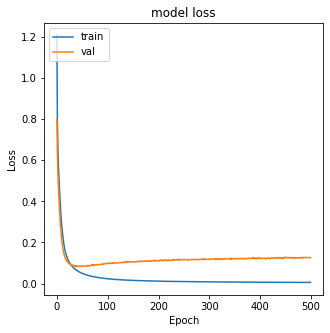

In [32]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
import numpy as np
#https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
plt.figure(figsize=(5,5))
plt.plot(train_loss_ex)
plt.plot(val_loss_ex)
#plt.yticks(np.arange(0.2, 1.5, step=0.1))
#plt.xticks(np.arange(1, 15, step=1))
plt.title("model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
import pandas as pd
#total_data_loss = pd.Series(epoch_ex,train_loss_ex,val_loss_ex)
total_train_loss = pd.Series(train_loss_ex)
total_val_loss = pd.Series(val_loss_ex)
total_train_loss=pd.DataFrame(total_train_loss, columns=["train loss"])
total_val_loss =pd.DataFrame(total_val_loss, columns=["val loss"])
total_data_loss=pd.concat([total_train_loss,total_val_loss], axis=1)
total_train_loss
total_data_loss.to_csv(r'total_loss_test2.csv',  index=None)

# Save model

In [33]:
#https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html

In [34]:
save_name="model_tranformer_epochs_"+str(NUM_EPOCHS)+"_test2"+".pth"
torch.save(transformer,save_name)

In [43]:
from google.colab import files
files.download(save_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

save file .pt

In [ ]:
save_name_pt="model_tranformer_epochs_"+str(NUM_EPOCHS)+".pt"
torch.save(transformer,save_name_pt)

In [72]:
files.download("/content/my_checkpoint_500_test2.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Load model

In [ ]:
model = torch.load('/content/gdrive/MyDrive/code retrosynthesis/model/model_tranformer_epochs_500.pth')
print(True)

True

#Translation greedy_decode

In [36]:
import pandas as pd
import numpy as np

In [44]:
df_src=pd.read_csv(src_filepath,names=["input"])
df_tgt=pd.read_csv(tgt_filepath,names=["target"])
df = pd.concat([df_src,df_tgt], axis=1)
df

,input,target
0,<RX_1> O = C 1 C C [ C @ H ] ( C N 2 C C N ( C...,C S ( = O ) ( = O ) O C [ C @ H ] 1 C C C ( = ...
1,<RX_6> N c 1 n c 2 [ n H ] c ( C C C c 3 c s c...,C O C ( = O ) c 1 c c ( C C C c 2 c c 3 c ( = ...
2,<RX_9> C C 1 ( C ) O B ( c 2 c c c c ( N c 3 n...,C C 1 ( C ) O B ( B 2 O C ( C ) ( C ) C ( C ) ...
3,<RX_6> C C ( C ) ( C ) O C ( = O ) N C C ( = O...,C C ( C ) ( C ) O C ( = O ) N C C ( = O ) C C ...
4,<RX_1> F c 1 c c 2 c ( N C 3 C C C C C C 3 ) n...,F c 1 c c 2 c ( C l ) n c n c 2 c n 1 . N C 1 ...
...,...,...
50032,<RX_1> C C ( C ) ( C ) O C ( = O ) N 1 C C c 2...,C C ( C ) ( C ) O C ( = O ) N 1 C C c 2 c c c ...
50033,<RX_2> C C ( = O ) O C C N C ( = O ) O C ( C )...,C C ( = O ) C l . C C ( C ) ( C ) O C ( = O ) ...
50034,<RX_3> C c 1 c c c ( - c 2 c c n c c 2 ) c c 1...,C c 1 c c c ( B r ) c c 1 C = O . O B ( O ) c ...
50035,<RX_1> C C ( C ) ( C ) O C 1 C [ C @ @ H ] 2 C...,C C ( C ) ( C ) O . O = C C 1 = C [ C @ H ] 2 ...


In [45]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        memory_mask = torch.zeros(ys.shape[0], memory.shape[0]).to(device).type(torch.bool)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        
        if next_word == EOS_IDX:
          break
    return ys


def translate(model, src, src_vocab, tgt_vocab, src_tokenizer):
  model.eval()
  tokens = [BOS_IDX] + [src_vocab.stoi[tok] for tok in src_tokenizer(src)]+ [EOS_IDX]
  num_tokens = len(tokens)
  src = (torch.LongTensor(tokens).reshape(num_tokens, 1) )
  src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
  #max_len affect accuracy.
  tgt_tokens = greedy_decode(model,  src, src_mask, max_len=num_tokens + 20, start_symbol=BOS_IDX).flatten()
 
  print("Product:"+ " "+df.input[i])
  print("Reaction Real:"+" "+df.target[i])
  return print("prediction:"+" ".join([tgt_vocab.itos[tok] for tok in tgt_tokens]).replace("<bos>", "").replace("<eos>", ""))
  #return " ".join([tgt_vocab.itos[tok] for tok in tgt_tokens]).replace("<bos>", "").replace("<eos>", "")

In [49]:
i=5006
translate(transformer, df.input[i], src_vocab, tgt_vocab, tokenizer)

Product: <RX_2> N [ C @ H ] 1 C C C [ C @ H ] 1 N S ( = O ) ( = O ) c 1 c c 2 c c ( C l ) c c
c 2 n 1 S ( = O ) ( = O ) c 1 c c c c c 1

Reaction Real: N [ C @ H ] 1 C C C [ C @ H ] 1 N . O = S ( = O ) ( C l ) c 1 c c 2 c c ( C l 
) c c c 2 n 1 S ( = O ) ( = O ) c 1 c c c c c 1

prediction: N [ C @ H ] 1 C C C [ C @ H ] 1 N . O = S ( = O ) ( C l ) c 1 c c 2 c c ( C l ) c
c c 2 n 1 S ( = O ) ( = O ) c 1 c c c c c 1

In [50]:
for i in range(50000,50010):
  translate(transformer, df.input[i], src_vocab, tgt_vocab, tokenizer)
  print("    ")

Product: <RX_9> O = C ( O ) C ( = O ) O

Reaction Real: C c 1 c c c ( B r ) c 2 c 1 C ( C ( C ) C ) N ( C ( = O ) C N C C 1 ( O ) C C 
C C C 1 ) C C 2

prediction: N # C c 1 c c ( F ) c ( C l ) c c 1 O [ C @ H ] ( C N = [ N + ] = [

Product: <RX_3> C C O C ( = O ) C = C C c 1 c c c ( B r ) c c 1

Reaction Real: C C O C ( = O ) C = P ( c 1 c c c c c 1 ) ( c 1 c c c c c 1 ) c 1 c c c c c 1 
. O = C C c 1 c c c ( B r ) c c 1

prediction: C C O C ( = O ) C P ( = O ) ( O C C ) O C C . O = C c 1 c c c ( B r ) c c 1

Product: <RX_6> C c 1 c c ( C 2 = N O C ( c 3 c c ( C l ) c c ( C l ) c 3 ) ( C ( F ) ( F ) F
) C 2 = N O ) c c c 1 C ( = O ) O

Reaction Real: C c 1 c c ( C 2 = N O C ( c 3 c c ( C l ) c c ( C l ) c 3 ) ( C ( F ) ( F ) F 
) C 2 = N O ) c c c 1 C ( = O ) O C ( C ) ( C ) C

prediction: C O C ( = O ) c 1 c c c ( C 2 = N O C ( c 3 c c ( C l ) c c ( C l ) c 3 ) ( C ( F
) ( F ) F ) C 2 = N O ) c c 1 C

Product: <RX_6> N # C c 1 n c c ( B r ) c ( N ( N ) C 2 C C O C C 2 ) n 1

Reaction Real: C C ( C ) ( C ) O C ( = O ) N N ( c 1 n c ( C # N ) n c c 1 B r ) C 1 C C O C 
C 1

prediction: C C ( C ) ( C ) O C ( = O ) N N ( c 1 n c ( C # N ) n c c 1 B r ) C 1 C C O C C 1

Product: <RX_2> O = C 1 C C C ( N 2 C c 3 c c ( C N C ( = O ) N 4 C C O C C 4 ) c c c 3 C 2 =
O ) C ( = O ) N 1

Reaction Real: N C c 1 c c c 2 c ( c 1 ) C N ( C 1 C C C ( = O ) N C 1 = O ) C 2 = O . O = C 
( C l ) N 1 C C O C C 1

prediction: N C c 1 c c c 2 c ( c 1 ) C N ( C 1 C C C ( = O ) N C 1 = O ) C 2 = O . O = C ( C
l ) N 1 C C O C C 1

Product: <RX_7> C c 1 c c c ( N ) c c 1 C ( = O ) N S ( C ) ( = O ) = O

Reaction Real: C c 1 c c c ( [ N + ] ( = O ) [ O - ] ) c c 1 C ( = O ) N S ( C ) ( = O ) = O

prediction: C c 1 c c c ( [ N + ] ( = O ) [ O - ] ) c c 1 C ( = O ) N S ( C ) ( = O ) = O

Product: <RX_6> O = C ( O ) C c 1 c c c 2 s c ( = O ) [ n H ] c 2 c 1

Reaction Real: C C O C ( = O ) C c 1 c c c 2 s c ( = O ) [ n H ] c 2 c 1

prediction: C C O C ( = O ) C c 1 c c c 2 s c ( = O ) [ n H ] c 2 c 1

Product: <RX_9> N C ( = O ) C 1 C C N ( C C C O c 2 c c c ( - n 3 n c 4 c c c c c 4 c 3 C l )
c c 2 ) C C 1

Reaction Real: N . O = C ( O ) C 1 C C N ( C C C O c 2 c c c ( - n 3 n c 4 c c c c c 4 c 3 C 
l ) c c 2 ) C C 1

prediction: C C O C ( = O ) C 1 C C N ( C C C O c 2 c c c ( - n 3 n c 4 c c c c c 4 c 3 C l )
c c 2 ) C C 1 . N

Product: <RX_2> C C ( C ) ( C ) c 1 c c c ( C N ( C C c 2 c c ( F ) c c ( C ( F ) ( F ) F ) c
2 ) C ( = O ) c 2 c c ( C ( F ) ( F ) F ) c c ( C l ) c 2 F ) c c 1

Reaction Real: C C ( C ) ( C ) c 1 c c c ( C N C C c 2 c c ( F ) c c ( C ( F ) ( F ) F ) c 2 
) c c 1 . O = C ( O ) c 1 c c ( C ( F ) ( F ) F ) c c ( C l ) c 1 F

prediction: C C ( C ) ( C ) c 1 c c c ( C N C C c 2 c c ( F ) c c ( C ( F ) ( F ) F ) c 2 ) c
c 1 . O = C ( O ) c 1 c c ( C ( F ) ( F ) F ) c c ( C l ) c 1 F

Product: <RX_1> C C O C ( = O ) c 1 c o c 2 c c ( N 3 C ( = O ) c 4 c c c c c 4 C 3 = O ) c c
c 1 2

Reaction Real: C C O C ( = O ) c 1 c o c 2 c c ( B r ) c c c 1 2 . O = C 1 N C ( = O ) c 2 c 
c c c c 2 1

prediction: C C O C ( = O ) c 1 c o c 2 c c ( N C ( = O ) c 3 c c c c c 3 C ( = O ) O C C ) c
c c 1 2

#Prediction Greedy decode

In [ ]:
df_test=pd.read_csv("/content/Retrosynthesis_TF/USPTO-50K/src/src-test.txt",names=["input"])
df_test

,input
0,<RX_1> C O C ( = O ) C C C ( = O ) c 1 c c c (...
1,<RX_4> C O C ( = O ) c 1 c c c c ( - c 2 n c 3...
2,<RX_2> C O N ( C ) C ( = O ) C 1 C C C ( N C (...
3,<RX_1> O = [ N + ] ( [ O - ] ) c 1 c c c ( C l...
4,<RX_9> N C C 1 = C C [ C @ @ H ] ( c 2 c c c (...
...,...
4999,<RX_1> C c 1 c c ( [ N + ] ( = O ) [ O - ] ) c...
5000,<RX_6> C O C ( = O ) c 1 [ n H ] c 2 c c ( C l...
5001,<RX_7> C O c 1 c c ( C ( F ) ( F ) F ) c c ( S...
5002,<RX_10> C c 1 n n ( C C ( C ) C O ) c ( - c 2 ...


In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        memory_mask = torch.zeros(ys.shape[0], memory.shape[0]).to(device).type(torch.bool)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        
        if next_word == EOS_IDX:
          break
    return ys


def translate(model, src, src_vocab, tgt_vocab, src_tokenizer):
  model.eval()
  tokens = [BOS_IDX] + [src_vocab.stoi[tok] for tok in src_tokenizer(src)]+ [EOS_IDX]
  num_tokens = len(tokens)
  src = (torch.LongTensor(tokens).reshape(num_tokens, 1) )
  src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
  tgt_tokens = greedy_decode(model,  src, src_mask, max_len=num_tokens + 20, start_symbol=BOS_IDX).flatten()
 
  #print("Product:"+ " "+df.input[i])
  #print("Reaction Real:"+" "+df.target[i])
  #return print("prediction:"+" ".join([tgt_vocab.itos[tok] for tok in tgt_tokens]).replace("<bos>", "").replace("<eos>", ""))
  return " ".join([tgt_vocab.itos[tok] for tok in tgt_tokens]).replace("<bos>", "").replace("<eos>", "")

In [ ]:
len(df_test.input)


5004

In [ ]:
#500 epoch
model = torch.load('/content/gdrive/MyDrive/code retrosynthesis/model/model_tranformer_epochs_500.pth')

In [ ]:
i=50034
translate(model, df.input[i], src_vocab, tgt_vocab, tokenizer)

' C c 1 c c c ( B r ) c c 1 C = O . O B ( O ) c 1 c c n c c 1'

In [ ]:
a=0
src_input=[]
for i in range(len(df_test)):
  #model
  translate_src=translate(model, df_text.input[i], src_vocab, tgt_vocab, tokenizer)
  #for n in range(1,11):
    #translate_src=translate(transformer, df.input[i], src_vocab, tgt_vocab, tokenizer)
  src_input.append(translate_src)
  a=a+1
print(a)         

5004

In [ ]:
df_test_prediction = pd.Series(src_input)
df_test_prediction

0        C 1 = C O C C C 1 . C O C ( = O ) C C C ( = O...
1        C O C ( = O ) c 1 c c c c ( C ( = O ) O ) c 1...
2        C C ( C ) ( C ) O C ( = O ) N C 1 C C C ( C (...
3        N c 1 c c c ( O ) c c 1 . O = [ N + ] ( [ O -...
4        [ N - ] = [ N + ] = N C C 1 = C C [ C @ @ H ]...
                              ...                        
4999     C c 1 c c ( [ N + ] ( = O ) [ O - ] ) c c c 1...
5000     C O C ( = O ) C C 1 C C c 2 c ( C l ) c c 3 [...
5001     C O c 1 c c ( C ( F ) ( F ) F ) c c ( S C ) c...
5002     C C ( C ) C n 1 n c ( C ) c ( B r ) c 1 - c 1...
5003     C O C ( = O ) c 1 c c ( S C c 2 c c c ( O C )...
Length: 5004, dtype: object

In [ ]:
df_test_prediction= pd.DataFrame(df_test_prediction, columns=["prediction"])
df_test_prediction

,prediction
0,C 1 = C O C C C 1 . C O C ( = O ) C C C ( = O...
1,C O C ( = O ) c 1 c c c c ( C ( = O ) O ) c 1...
2,C C ( C ) ( C ) O C ( = O ) N C 1 C C C ( C (...
3,N c 1 c c c ( O ) c c 1 . O = [ N + ] ( [ O -...
4,[ N - ] = [ N + ] = N C C 1 = C C [ C @ @ H ]...
...,...
4999,C c 1 c c ( [ N + ] ( = O ) [ O - ] ) c c c 1...
5000,C O C ( = O ) C C 1 C C c 2 c ( C l ) c c 3 [...
5001,C O c 1 c c ( C ( F ) ( F ) F ) c c ( S C ) c...
5002,C C ( C ) C n 1 n c ( C ) c ( B r ) c 1 - c 1...


In [ ]:
#save df to .txt

In [ ]:
#https://stackoverflow.com/questions/31247198/python-pandas-write-content-of-dataframe-into-text-file
df_test_prediction.to_csv(r'predictions_top1.txt', header=None, index=None)


NameError: ignored

In [ ]:
from google.colab import files
files.download('predictions_top1.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#beam search 

In [51]:
import pandas as pd
import numpy as np
df_src=pd.read_csv(src_filepath,names=["input"])
df_tgt=pd.read_csv(tgt_filepath,names=["target"])
df = pd.concat([df_src,df_tgt], axis=1)

In [52]:
df_test=pd.read_csv("/content/Retrosynthesis_TF/USPTO-50K/src/src-test.txt",names=["input"])
df_test

,input
0,<RX_1> C O C ( = O ) C C C ( = O ) c 1 c c c (...
1,<RX_4> C O C ( = O ) c 1 c c c c ( - c 2 n c 3...
2,<RX_2> C O N ( C ) C ( = O ) C 1 C C C ( N C (...
3,<RX_1> O = [ N + ] ( [ O - ] ) c 1 c c c ( C l...
4,<RX_9> N C C 1 = C C [ C @ @ H ] ( c 2 c c c (...
...,...
4999,<RX_1> C c 1 c c ( [ N + ] ( = O ) [ O - ] ) c...
5000,<RX_6> C O C ( = O ) c 1 [ n H ] c 2 c c ( C l...
5001,<RX_7> C O c 1 c c ( C ( F ) ( F ) F ) c c ( S...
5002,<RX_10> C c 1 n n ( C C ( C ) C O ) c ( - c 2 ...


https://towardsdatascience.com/foundations-of-nlp-explained-visually-beam-search-how-it-works-1586b9849a24

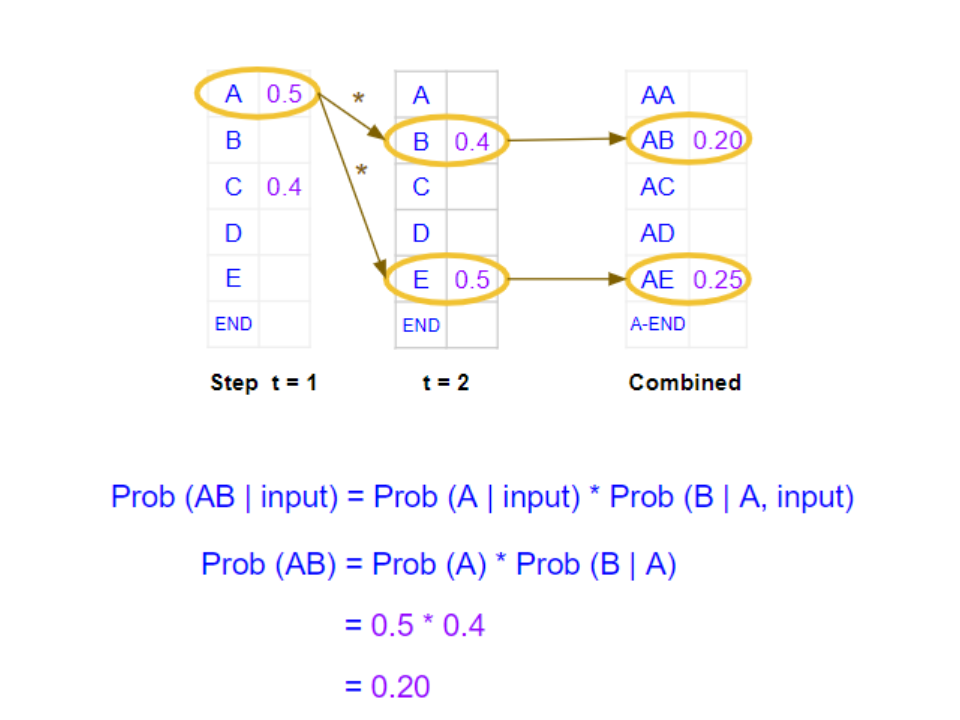

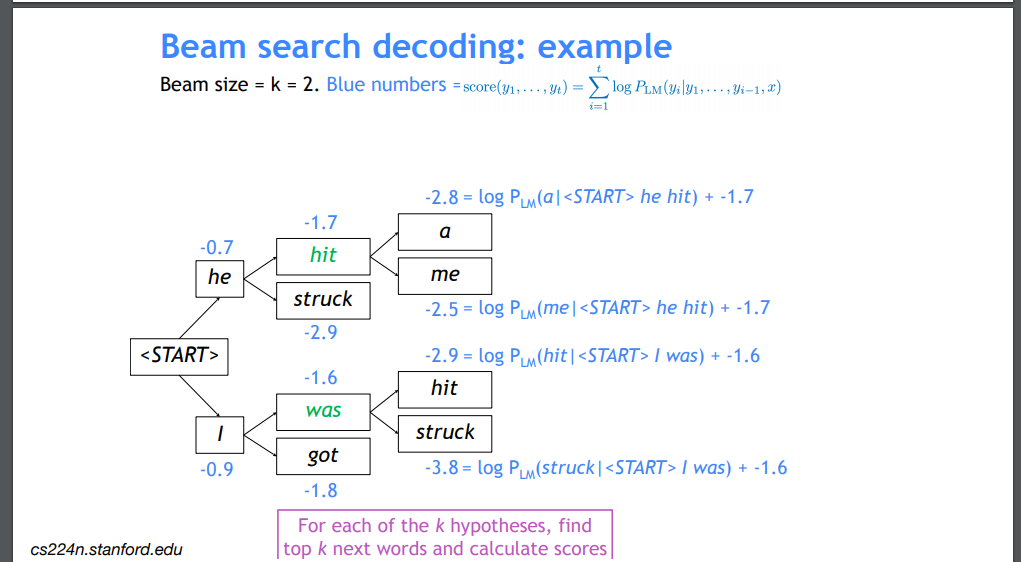

ref https://attapol.github.io/compling/slides/machine-translation-2020.pdf

In [ ]:
#https://towardsdatascience.com/boosting-your-sequence-generation-performance-with-beam-search-language-model-decoding-74ee64de435a

import numpy as np
import math

def beam_search_decoder(predictions, top_k = 3):
    #start with an empty sequence with zero score
    output_sequences = [([], 0)]
    
    #looping through all the predictions
    for token_probs in predictions:
        new_sequences = []
        
        #append new tokens to old sequences and re-score
        for old_seq, old_score in output_sequences:
            for char_index in range(len(token_probs)):
                
                new_seq = old_seq + [char_index]
                print(old_seq)
                print(new_seq)
                #considering log-likelihood for scoring
                new_score = old_score + math.log(token_probs[char_index])
                #print(old_score )
                #print(new_seq, new_score)
                #print(token_probs[char_index],math.log(token_probs[char_index]))
                new_sequences.append((new_seq, new_score))
                #print(new_sequences)
                
        #sort all new sequences in the de-creasing order of their score
        output_sequences = sorted(new_sequences, key = lambda val: val[1], reverse = True)
        
        #select top-k based on score 
        # *Note- best sequence is with the highest score
        output_sequences = output_sequences[:top_k]
        
    return output_sequences
    

model_prediction = [[0.1, 0.7, 0.1, 0.1],
                    [0.7, 0.1, 0.1, 0.1],
                    [0.1, 0.1, 0.6, 0.2],
                    [0.1, 0.1, 0.1, 0.7],
                    [0.4, 0.3, 0.2, 0.1]]
                    
beam_search_decoder(model_prediction, top_k = 5)



[]

[0]

[]

[1]

[]

[2]

[]

[3]

[1]

[1, 0]

[1]

[1, 1]

[1]

[1, 2]

[1]

[1, 3]

[0]

[0, 0]

[0]

[0, 1]

[0]

[0, 2]

[0]

[0, 3]

[2]

[2, 0]

[2]

[2, 1]

[2]

[2, 2]

[2]

[2, 3]

[3]

[3, 0]

[3]

[3, 1]

[3]

[3, 2]

[3]

[3, 3]

[1, 0]

[1, 0, 0]

[1, 0]

[1, 0, 1]

[1, 0]

[1, 0, 2]

[1, 0]

[1, 0, 3]

[1, 1]

[1, 1, 0]

[1, 1]

[1, 1, 1]

[1, 1]

[1, 1, 2]

[1, 1]

[1, 1, 3]

[1, 2]

[1, 2, 0]

[1, 2]

[1, 2, 1]

[1, 2]

[1, 2, 2]

[1, 2]

[1, 2, 3]

[1, 3]

[1, 3, 0]

[1, 3]

[1, 3, 1]

[1, 3]

[1, 3, 2]

[1, 3]

[1, 3, 3]

[0, 0]

[0, 0, 0]

[0, 0]

[0, 0, 1]

[0, 0]

[0, 0, 2]

[0, 0]

[0, 0, 3]

[1, 0, 2]

[1, 0, 2, 0]

[1, 0, 2]

[1, 0, 2, 1]

[1, 0, 2]

[1, 0, 2, 2]

[1, 0, 2]

[1, 0, 2, 3]

[1, 0, 3]

[1, 0, 3, 0]

[1, 0, 3]

[1, 0, 3, 1]

[1, 0, 3]

[1, 0, 3, 2]

[1, 0, 3]

[1, 0, 3, 3]

[1, 0, 0]

[1, 0, 0, 0]

[1, 0, 0]

[1, 0, 0, 1]

[1, 0, 0]

[1, 0, 0, 2]

[1, 0, 0]

[1, 0, 0, 3]

[1, 0, 1]

[1, 0, 1, 0]

[1, 0, 1]

[1, 0, 1, 1]

[1, 0, 1]

[1, 0, 1, 2]

[1, 0, 1]

[1, 0, 1, 3]

[1, 1, 2]

[1, 1, 2, 0]

[1, 1, 2]

[1, 1, 2, 1]

[1, 1, 2]

[1, 1, 2, 2]

[1, 1, 2]

[1, 1, 2, 3]

[1, 0, 2, 3]

[1, 0, 2, 3, 0]

[1, 0, 2, 3]

[1, 0, 2, 3, 1]

[1, 0, 2, 3]

[1, 0, 2, 3, 2]

[1, 0, 2, 3]

[1, 0, 2, 3, 3]

[1, 0, 3, 3]

[1, 0, 3, 3, 0]

[1, 0, 3, 3]

[1, 0, 3, 3, 1]

[1, 0, 3, 3]

[1, 0, 3, 3, 2]

[1, 0, 3, 3]

[1, 0, 3, 3, 3]

[1, 0, 0, 3]

[1, 0, 0, 3, 0]

[1, 0, 0, 3]

[1, 0, 0, 3, 1]

[1, 0, 0, 3]

[1, 0, 0, 3, 2]

[1, 0, 0, 3]

[1, 0, 0, 3, 3]

[1, 0, 1, 3]

[1, 0, 1, 3, 0]

[1, 0, 1, 3]

[1, 0, 1, 3, 1]

[1, 0, 1, 3]

[1, 0, 1, 3, 2]

[1, 0, 1, 3]

[1, 0, 1, 3, 3]

[1, 0, 2, 0]

[1, 0, 2, 0, 0]

[1, 0, 2, 0]

[1, 0, 2, 0, 1]

[1, 0, 2, 0]

[1, 0, 2, 0, 2]

[1, 0, 2, 0]

[1, 0, 2, 0, 3]

[([1, 0, 2, 3, 0], -2.497141187456343),
 ([1, 0, 2, 3, 1], -2.784823259908124),
 ([1, 0, 2, 3, 2], -3.1902883680162883),
 ([1, 0, 3, 3, 0], -3.595753476124453),
 ([1, 0, 2, 3, 3], -3.8834355485762337)]

In [ ]:
#https://github.com/bigchem/synthesis/blob/master/transformer.py

In [53]:
def beam_decode(model, src, src_mask, max_len, start_symbol,k):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    output_sequences = [([], 0)]
    old_prob=[]
    new_prob=[]
    old_score=[]
    old_index=[]
    new_index=[]
    new_sequences=[]
    a=[]
    test_seq=[]

    for i in range(max_len-1):
        memory = memory.to(device)
        memory_mask = torch.zeros(ys.shape[0], memory.shape[0]).to(device).type(torch.bool)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        #print(prob)



        #note topK
        prb,next_topk=torch.topk(prob,k,dim=1)
        
        #print(torch.topk(prob,k,dim=1))
        #keep default prb
        if i==0:
          #print(torch.topk(prob,k,dim=1))

          for n in range(k):
            #keep prob
            old_prob.append(prb[0][n].item())
            #keep index
            old_seq=[next_topk[0][n].item()]
            old_index.append(old_seq)
          #print(old_index)
          #print(old_index[0]+[next_topk[0][0].item()])

            #new_sequences.append((prb[0][n].item(),next_topk[0][n].item()))
          #print(old_prob)
          #print(old_index)
          #old_prob_tensor=torch.tensor([old_prob]).to(device)
          #old_index_tensor=torch.tensor([old_index]).to(device)
          #print(old_prob_tensor)
          #b=torch.tensor([new_sequences]).to(device)
          #print(b[:][0])
          #a=a.transpose(0, 1)
          #a=a[:,-1]
          #print(a)
          #print(torch.topk(b,k,dim=1))
          #print(b[:][0].item())
 



          #print(old_index) 
         #print(new_sequences)
          #print(new_sequences[1])
   
         
          #old_index_tensor=torch.cat(old_index_tensor,old_index_tensor,dim=0)
          #print(old_index_tensor)


        #print(prb[0][0])
        #print(next_topk[0][0])
        #_, next_word = torch.max(prob, dim = 1)
        #next_word = next_word.item()

        #key pull number out tensor
        if i>=1:
          #print(torch.topk(prob,k,dim=1))
          for n in range(k):
            for m in range(k):
              #update prob 
              ref_prob=old_prob[n]+prb[0][m].item()
              new_prob.append(ref_prob)
              #updata index
              ref_index=old_index[n]+[next_topk[0][m].item()]
              new_index.append(ref_index)
            
          
          new_prob_tensor=torch.tensor([new_prob]).to(device)
          new_prob_topk,new_index_topk=torch.topk(new_prob_tensor,k=10,dim=1)
          

          #print("position",new_index_topk)
          for n in range(k):
            old_prob[n]=new_prob_topk[0][n].item()
            #new_index_topk[0][n].item()
            old_index[n]=new_index[new_index_topk[0][n].item()]
            
          new_prob.clear()
          new_index.clear()
          
          
    
        next_topk_k=next_topk[0][0].item()
        ys = torch.cat([ys,torch.ones(1, 1).type_as(src.data).fill_(next_topk_k)], dim=0)
        #final_beam
        final_beam=old_index
        if next_topk_k== EOS_IDX:
          #print(old_prob)
          #print(old_index)
          
          break
    return ys,final_beam


def translate_beam(model, src, src_vocab, tgt_vocab, src_tokenizer,k):
  model.eval()
  keep_prediction=[]
  tokens = [BOS_IDX] + [src_vocab.stoi[tok] for tok in src_tokenizer(src)]+ [EOS_IDX]
  num_tokens = len(tokens)
  src = (torch.LongTensor(tokens).reshape(num_tokens, 1) )
  src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
  tgt_tokens,pretest = beam_decode(model,  src, src_mask, max_len=num_tokens + 30, start_symbol=BOS_IDX,k=10)#.flatten()
  #print(tgt_tokens,len(tgt_tokens))
  print("Product:"+ " "+df.input[i])
  print("Reaction Real:"+" "+df.target[i])
  #print("prediction:"+" ".join([tgt_vocab.itos[tok] for tok in tgt_tokens]).replace("<bos>", "").replace("<eos>", ""))
  for o in range(k):
    a=torch.tensor(pretest[o]).to(device)
    #"prediction "+"Top"+str(o)+": "+" ".join([tgt_vocab.itos[tok] for tok in a]).replace("<bos>", "").replace("<eos>", "")
    print("prediction "+"Top"+str(o+1)+": "+" ".join([tgt_vocab.itos[tok] for tok in a]).replace("<bos>", "").replace("<eos>", ""))
    #pi=print(" ".join([tgt_vocab.itos[tok] for tok in a]).replace("<bos>", "").replace("<eos>", ""))
    
  #return "prediction "+"Top"+str(o+1)+": "+" ".join([tgt_vocab.itos[tok] for tok in a]).replace("<bos>", "").replace("<eos>", "")
  #print("prediction:"+" ".join([tgt_vocab.itos[tok] for tok in a]).replace("<bos>", "").replace("<eos>", ""))
  #return " ".join([tgt_vocab.itos[tok] for tok in tgt_tokens]).replace("<bos>", "").replace("<eos>", "")

In [66]:
i=5
translate_beam(transformer, df_test.input[i], src_vocab, tgt_vocab, tokenizer,k=10)

['C C c 1 o c ( - c 2 c c c ( C ( F ) ( F ) F ) c c 2 ) n c 1 C O C [ C @ @ H ] 1 C C C [ C @ H ] ( C O C ( C ) ( C ) C ( = O ) O C ) C 1 ',
 'C C O 1 o c ( - c 2 c c c ( C ( F ) ( F ) F ) c c 2 ) n c 1 C O C [ C @ @ H ] 1 C C C [ C @ H ] ( C O C ( C ) ( C ) C ( = O ) O C ) C 1 ',
 'C C c 1 o c ( - c 2 c c c ( C ( F ) ( F ) F ) c c 2 ) n c 1 C O C [ C @ @ H ] 1 C C C [ C @ H ] ( C O C ( C ) ( C ) C ( = O ) O C ( C 1 ',
 'C C c 1 o c ( - c 2 c c c ( C ( F ) ( F ) F ) c c 2 ) n c 1 C O C [ C @ @ H ] 1 C C C [ C @ H ] ( C O C ( C ) ( C ) C ( = O ) O C C C 1 ',
 'C C O 1 o c ( - c 2 c c c ( C ( F ) ( F ) F ) c c 2 ) n c 1 C O C [ C @ @ H ] 1 C C C [ C @ H ] ( C O C ( C ) ( C ) C ( = O ) O C ( C 1 ',
 'C C C 1 o c ( - c 2 c c c ( C ( F ) ( F ) F ) c c 2 ) n c 1 C O C [ C @ @ H ] 1 C C C [ C @ H ] ( C O C ( C ) ( C ) C ( = O ) O C ) C 1 ',
 'C C c 1 o c ( - c 2 c c c ( C ( F ) ( F ) F ) c c 2 ) n c 1 C O C [ C @ @ H ] 1 C C C [ C @ H ] ( C O C ( C ) ( C ) C ( = O ) O C  C 1 ',
 'C C c 1 o c 

In [ ]:
Product: <RX_1> C N C C C n 1 c 2 c c c ( O ) c c 2 c 2 c 3 c ( c ( - c 4 c c c c c 4 ) c c 2
1 ) C ( = O ) N C 3 = O
Reaction Real: C N . O = C 1 N C ( = O ) c 2 c 1 c ( - c 1 c c c c c 1 ) c c 1 c 2 c 2 c c ( 
O ) c c c 2 n 1 C C C B r
prediction: C C ( C ) C n 1 n c ( C ) c ( B r ) c 1 - c 1 c c c ( F ) c c 1 . O = C 1 C C C

In [ ]:
print(len("C O C ( = O ) c 1 c c c c ( C ( = O ) O ) c 1 . N c 1 c c c n c 1 N".replace(" ", "")))

34

#Prediction Beam Search decode


In [61]:
import pandas as pd
import numpy as np
df_test=pd.read_csv("/content/Retrosynthesis_TF/USPTO-50K/src/src-test.txt",names=["input"])
df_test

,input
0,<RX_1> C O C ( = O ) C C C ( = O ) c 1 c c c (...
1,<RX_4> C O C ( = O ) c 1 c c c c ( - c 2 n c 3...
2,<RX_2> C O N ( C ) C ( = O ) C 1 C C C ( N C (...
3,<RX_1> O = [ N + ] ( [ O - ] ) c 1 c c c ( C l...
4,<RX_9> N C C 1 = C C [ C @ @ H ] ( c 2 c c c (...
...,...
4999,<RX_1> C c 1 c c ( [ N + ] ( = O ) [ O - ] ) c...
5000,<RX_6> C O C ( = O ) c 1 [ n H ] c 2 c c ( C l...
5001,<RX_7> C O c 1 c c ( C ( F ) ( F ) F ) c c ( S...
5002,<RX_10> C c 1 n n ( C C ( C ) C O ) c ( - c 2 ...


In [62]:
def beam_decode(model, src, src_mask, max_len, start_symbol,k):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    output_sequences = [([], 0)]
    old_prob=[]
    new_prob=[]
    old_score=[]
    old_index=[]
    new_index=[]
    new_sequences=[]
    a=[]
    test_seq=[]

    for i in range(max_len-1):
        memory = memory.to(device)
        memory_mask = torch.zeros(ys.shape[0], memory.shape[0]).to(device).type(torch.bool)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
      
        #note topK
        prb,next_topk=torch.topk(prob,k,dim=1)
        
        #keep default probability
        if i==0:
          for n in range(k):
            #keep prob
            old_prob.append(prb[0][n].item())
            #keep index
            old_seq=[next_topk[0][n].item()]
            old_index.append(old_seq)
        
        #key pull number out tensor
        if i>=1:
          #print(torch.topk(prob,k,dim=1))
          for n in range(k):
            for m in range(k):
              #update prob 
              ref_prob=old_prob[n]+prb[0][m].item()
              new_prob.append(ref_prob)
              #updata index
              ref_index=old_index[n]+[next_topk[0][m].item()]
              new_index.append(ref_index)
            
          
          new_prob_tensor=torch.tensor([new_prob]).to(device)
          new_prob_topk,new_index_topk=torch.topk(new_prob_tensor,k=10,dim=1)
          

          #print("position",new_index_topk)
          for n in range(k):
            old_prob[n]=new_prob_topk[0][n].item()
            #new_index_topk[0][n].item()
            old_index[n]=new_index[new_index_topk[0][n].item()]
            
          new_prob.clear()
          new_index.clear()
          
          
    
        next_topk_k=next_topk[0][0].item()
        ys = torch.cat([ys,torch.ones(1, 1).type_as(src.data).fill_(next_topk_k)], dim=0)
        #final_beam
        final_beam=old_index
        if next_topk_k== EOS_IDX:
          #print(old_prob)
          #print(old_index)
          
          break
    return ys,final_beam


def translate_beam(model, src, src_vocab, tgt_vocab, src_tokenizer,k):
  model.eval()
  keep_prediction=[]
  tokens = [BOS_IDX] + [src_vocab.stoi[tok] for tok in src_tokenizer(src)]+ [EOS_IDX]
  num_tokens = len(tokens)
  src = (torch.LongTensor(tokens).reshape(num_tokens, 1) )
  src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
  tgt_tokens,pretest = beam_decode(model,  src, src_mask, max_len=num_tokens + 20, start_symbol=BOS_IDX,k=10)#.flatten()
  for o in range(k):
    a=torch.tensor(pretest[o]).to(device)
    #print(" ".join([tgt_vocab.itos[tok] for tok in a]).replace("<bos>", "").replace("<eos>", ""))
    keep_prediction.append(" ".join([tgt_vocab.itos[tok] for tok in a]).replace("<bos>", "").replace("<eos>", ""))
  return keep_prediction
    
  

In [63]:
i=5001
translate_beam(transformer, df_test.input[i], src_vocab, tgt_vocab, tokenizer,k=10)

['C O c 1 c c ( C ( F ) ( F ) F ) c c ( S C ) c 1 C ( = O ) N C 1 ( c 2 c c c c c 2 ) C C ( = O ) C N ( C ) C 1 ',
 'C O C 1 c c ( C ( F ) ( F ) F ) c c ( S C ) c 1 C ( = O ) N C 1 ( c 2 c c c c c 2 ) C C ( = O ) C N ( C ) C 1 ',
 'C O c 1 c c ( C ( F ) ( F ) F ) c c ( S C ) c 1 C ( = O ) N C 1 ( c 2 c c c c c 2 ) C C ( O O ) C N ( C ) C 1 ',
 'C O C 1 c c ( C ( F ) ( F ) F ) c c ( S C ) c 1 C ( = O ) N C 1 ( c 2 c c c c c 2 ) C C ( O O ) C N ( C ) C 1 ',
 'C O c 1 c c ( C ( F ) ( F ) F ) c c ( S C ) c 1 C ( = O ) N C 1 ( c 2 c c c c c 2 ) C [ ( = O ) C N ( C ) C 1 ',
 'C O C 1 c c ( C ( F ) ( F ) F ) c c ( S C ) c 1 C ( = O ) N C 1 ( c 2 c c c c c 2 ) C [ ( = O ) C N ( C ) C 1 ',
 'C O c 1 c c ( C ( F ) ( F ) F ) c c ( S C ) c 1 C ( = O ) N [ 1 ( c 2 c c c c c 2 ) C C ( = O ) C N ( C ) C 1 ',
 'C C c 1 c c ( C ( F ) ( F ) F ) c c ( S C ) c 1 C ( = O ) N C 1 ( c 2 c c c c c 2 ) C C ( = O ) C N ( C ) C 1 ',
 'C O c 1 c c ( C ( F ) ( F ) F ) c c ( S C ) c 1 C ( = O ) N c 1 ( c 2 c c c c 

In [67]:
count_topk=0
src_input=[]
for i in range(len(df_test)):
  pre_beam=translate_beam(transformer, df_test.input[i], src_vocab, tgt_vocab, tokenizer,k=10)
  for q in range(len(pre_beam)):
    src_input.append(pre_beam[q])
print("Final")

Final

In [68]:
df_test_prediction = pd.Series(src_input)
df_test_prediction

0        C 1 = C O C C C 1 . C O C ( = O ) C C C ( = O ...
1        B 1 = C O C C C 1 . C O C ( = O ) C C C ( = O ...
2        C 1 = C O C C C 1 . C O C ( = O ) C C C ( = O ...
3        C C = C O C C C 1 . C O C ( = O ) C C C ( = O ...
4        C 1 = O O C C C 1 . C O C ( = O ) C C C ( = O ...
                               ...                        
50035    C O C ( = O ) c 1 c c ( S ) c 2 c c c ( O C ) ...
50036    C O C ( = O ) c 1 c c ( F C c 2 c c c ( O C ) ...
50037    C O C ( = O ) c 1 c c ( S ) c 2 c c c ( O C ) ...
50038    C O C ( = O ) c 1 c c ( S C c 2 c c c ( O C ) ...
50039    C O C ( = O ) c 1 c c ( S C c 2 c c c ( O C ) ...
Length: 50040, dtype: object

In [69]:
df_test_prediction= pd.DataFrame(df_test_prediction, columns=["prediction"])
df_test_prediction

,prediction
0,C 1 = C O C C C 1 . C O C ( = O ) C C C ( = O ...
1,B 1 = C O C C C 1 . C O C ( = O ) C C C ( = O ...
2,C 1 = C O C C C 1 . C O C ( = O ) C C C ( = O ...
3,C C = C O C C C 1 . C O C ( = O ) C C C ( = O ...
4,C 1 = O O C C C 1 . C O C ( = O ) C C C ( = O ...
...,...
50035,C O C ( = O ) c 1 c c ( S ) c 2 c c c ( O C ) ...
50036,C O C ( = O ) c 1 c c ( F C c 2 c c c ( O C ) ...
50037,C O C ( = O ) c 1 c c ( S ) c 2 c c c ( O C ) ...
50038,C O C ( = O ) c 1 c c ( S C c 2 c c c ( O C ) ...


In [70]:
df_test_prediction.to_csv(r'predictions_top10_test2.txt', header=None, index=None)

In [71]:
from google.colab import files
files.download('predictions_top10_test2.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>